In [ ]:
!pip install tensorflow_addons
!pip install --upgrade gensim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r "/content/drive/My Drive/dependency_treebank" "dependency_treebank"

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import functools
from typing import List, Callable, Dict, Iterable, Tuple, Set
from collections import OrderedDict

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
import keras as ks

import gensim
import gensim.downloader as gloader

from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
#Config
words_separator = ' '
banned_tags = [',', '.', '``', "''", ':', '$', '-LRB-', '-RRB-', '#', 'SYM']

In [4]:
# util
def flatten(seq: Iterable[Iterable]) -> List:
    return [item for inner in seq for item in inner]

@tf.function
def tf_in(x, y) -> tf.Tensor:
  '''
  Returns True for each element of x that is contained in y
  '''
  # Exploit broadcasting to compute y_true in filters
  # x:      N, 1
  # y:      1, M
  # x==y :  N x M
  # boolean mask:   N

  x = tf.expand_dims(x, axis=-1) # x:  N x 1
  return tf.math.reduce_any(x==y, axis=-1)

# 1 Dataset Creation and Loading

In [5]:
def read_tagged_sentences(filename: str) -> List[str]:
    with open(filename, mode='r', encoding='utf-8') as text_file:  
        corpus = text_file.read()
        return corpus.split("\n\n")

def get_tagged_words(tagged_sentence: str) -> List[str]:
    return tagged_sentence.rstrip('\n').split("\n")

def split_words_and_tags(tagged_words: List[str]) -> Tuple[List[str], List[str]]:
    words = []
    tags = []
    for tagged_word in tagged_words:
        word, tag = split_word_and_tag(tagged_word)
        words.append(word)
        tags.append(tag)
    return words, tags

def split_word_and_tag(tagged_word: str) -> Tuple[str, str]:
    entity = tagged_word.split("\t")
    # (word, tag)
    return entity[0], entity[1]

def read_data(filename) -> Tuple[List[str], List[str]]:
    tagged_sentences = read_tagged_sentences(filename)
    
    sentences: List[str] = []
    labels: List[str] = []
    for tagged_sentence in tagged_sentences:
        tagged_words = get_tagged_words(tagged_sentence)
        words, tags = split_words_and_tags(tagged_words)
        sentences.append(words_separator.join(words))
        labels.append(words_separator.join(tags))

    assert len(sentences) == len(tagged_sentences)
    assert len(labels) == len(tagged_sentences)

    return sentences, labels

def create_dataset(dataset_name="dependency_treebank", train_split=100, validation_split=150, test_split=199):
    def file_id_to_split(file_id: int):
        assert file_id <= test_split

        if file_id <= train_split:
            return 'train'
        if file_id <= validation_split:
            return 'validation'
        
        return 'test'

    dataset_folder = os.path.join(os.getcwd(), dataset_name)
    file_ids = []
    sentences = []
    labels = []
    for file_id in tqdm(range(1, test_split+1)):
        filename = os.path.join(dataset_folder, "wsj_%04d.dp" % file_id)
        sentences_, labels_ = read_data(filename)
        sentences += sentences_
        labels += labels_
        file_ids += [file_id] * len(sentences_)
         
    df = pd.DataFrame({'sentence': sentences, 'pos': labels, 'file_id': file_ids})
    df['split'] = df['file_id'].apply(file_id_to_split)
    
    df.to_pickle(os.path.join(os.getcwd(), dataset_name + ".pkl"))
    df.to_json(os.path.join(os.getcwd(), dataset_name + ".json"))
    return df

print("Creating dataset...")
df = create_dataset()
print("Creation completed!")

df

Creating dataset...


100%|██████████| 199/199 [00:00<00:00, 796.63it/s]

Creation completed!


,sentence,pos,file_id,split
0,"Pierre Vinken , 61 years old , will join the b...","NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN ...",1,train
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...","NNP NNP VBZ NN IN NNP NNP , DT NNP VBG NN .",1,train
2,"Rudolph Agnew , 55 years old and former chairm...","NNP NNP , CD NNS JJ CC JJ NN IN NNP NNP NNP NN...",2,train
3,A form of asbestos once used to make Kent ciga...,DT NN IN NN RB VBN TO VB NNP NN NNS VBZ VBN DT...,3,train
4,"The asbestos fiber , crocidolite , is unusuall...","DT NN NN , NN , VBZ RB JJ IN PRP VBZ DT NNS , ...",3,train
...,...,...,...,...
3909,They also said that more than a dozen presiden...,PRP RB VBD IN JJR IN DT NN NNS VBP VBN IN JJ N...,198,test
3910,Sen. Kennedy said in a separate statement that...,NNP NNP VBD IN DT JJ NN IN PRP VBZ NN TO VB DT...,198,test
3911,Trinity Industries Inc. said it reached a prel...,NNP NNPS NNP VBD PRP VBD DT JJ NN TO VB CD NN ...,199,test
3912,Terms were n't disclosed .,NNS VBD RB VBN .,199,test


## 1.1 Data Analysis and Exploration

### 1.1.1 Words analysis

In [6]:
words = flatten((sentence.split(words_separator) for sentence in df.sentence))
unique_words = set(flatten((sentence.split(words_separator) for sentence in df.sentence)))
lower_case_words = set(map(str.lower, words))
n_words = len(unique_words)

print("Total number of tagged sentences: {}".format(len(df)))
print("Total number of words: {}".format(n_words))
print("Total number of lowered case words: {}".format(len(lower_case_words)))

Total number of tagged sentences: 3914
Total number of words: 11968
Total number of lowered case words: 10947


In [7]:
difference = unique_words.difference(lower_case_words)
print(len(difference))
difference

3253


{'Noriega',
 'Pat',
 'TO',
 'Darkhorse',
 'Party',
 'Cancer',
 'Newsweek',
 'Melamed',
 'Modifications',
 'Where',
 'S&L',
 'Philippines',
 'Representative',
 'Ortega',
 'Magleby',
 'Pretty',
 'Bolduc',
 'Hiroshima',
 'Manchester',
 'Dresser',
 'Fourteen',
 'San',
 'Corton-Charlemagne',
 'Typical',
 'Raton',
 'While',
 'Nationale',
 'Pattenden',
 'Bugs',
 'Documents',
 'Being',
 'Pittsburgh',
 'Opportunity',
 'Porter',
 'N.Y.',
 'Freeport-McMoRan',
 'Encouraging',
 'Lakes',
 'COLLECTING',
 'Professors',
 'Bon',
 'Take',
 'Medical',
 'Upjohn',
 'Nilson',
 'Cedric',
 'Analysts',
 'SHAREDATA',
 'Datapoint',
 '-LRB-',
 'Contras',
 'Minn.',
 'Paul',
 'System',
 'After',
 'Renaissance-style',
 'Appeals',
 'Swearingen',
 'Graduate',
 'Rudolph',
 'Chafic',
 'Budget',
 'IOUs',
 'Either',
 'UPHELD',
 'Logic',
 'Arighi',
 'Grant',
 'Glendale',
 'Ralston',
 'SEC',
 'Dodge',
 'Rumors',
 'Herrington',
 'Mrs.',
 'Patch',
 'Hours',
 'Israel',
 'Hans',
 'ASSOCIATION',
 'Stamford',
 'Shipments',
 'Canad

There are sveral uppercase words:
1. -RRB-, -LRB- are already encoded into their tags
2. Most of them are abbreviations, e.g. S.V., U.S.A.
3. Some of them seem to be part of a title, e.g. PHOTOGRAPH, ASSOCIATION

In [8]:
uppercase_words = [word for word in difference if str.isupper(word)]
tags = set(flatten((pos.split(words_separator) for pos in df.pos)))
print('Words encoded into their tags', tags.intersection(uppercase_words))
uppercase_words

Words encoded into their tags {'-LRB-', '-RRB-', 'TO'}


['TO',
 'S&L',
 'N.Y.',
 'COLLECTING',
 'SHAREDATA',
 '-LRB-',
 'UPHELD',
 'SEC',
 'ASSOCIATION',
 'O.',
 'MITI',
 'SAT',
 'EXCHANGE',
 'CERTIFICATES',
 'COMPUTERS',
 'W.D.',
 'HHS',
 'NIH',
 'G.',
 'AT&T',
 'TROUBLES',
 'N.C.',
 'AGREES',
 'B-1B',
 'TRS-80',
 'III',
 'N.C',
 'NEW',
 'A.',
 'WFRR',
 'N.Y',
 'ABA',
 'RBC',
 'SOYBEANS',
 'UAL',
 'PC',
 'INTERPUBLIC',
 'ASSOCIATES',
 'W.R.',
 'DIAPER',
 'ISSUES',
 'DES',
 'CORP',
 'POP',
 'LATE',
 'MEDICINE',
 'PLO',
 'GRAINS',
 'FAMILY',
 'EEOC',
 'CSV',
 'A-D',
 'AC-130U',
 'FUNDS',
 'JUDGE',
 'COMMERCIAL',
 'OK',
 'U.K.',
 'NRDC',
 'Z.',
 'US$',
 'W.',
 'DDB',
 'CS',
 'WHAS',
 'PORTING',
 'FT-SE',
 'TRANSPLANT',
 'HUD',
 'AIDS',
 'PRIME',
 'ACCEPTANCES',
 'TEXAS',
 'H.',
 'PHOTOGRAPH',
 'TRIAL',
 'PRODUCTS',
 'WTD',
 'FERC',
 'IBC',
 'APPEARS',
 'N.H.',
 'ACCOUNT',
 'N.V.',
 'RMS',
 'GOODY',
 'FEDERAL',
 'NEC',
 'NCR',
 'TRUST',
 'DISCOUNT',
 'ASLACTON',
 'F.W.',
 'J.L.',
 'SWITCHING',
 'THE',
 'MERRILL',
 'EST',
 'RATES',
 'NYSE',
 'I

Words starting with capital letter are proper noun or words at the beginning of a sentence. Therefore, this carries an important piece of information for POS tagging.

In [9]:
capitalized_words = set([word for word in difference if str.isupper(word[0])])
capitalized_words = capitalized_words.difference(uppercase_words)
print('Capitalized words:', len(capitalized_words))
capitalized_words

Capitalized words: 2945


{'Noriega',
 'Pat',
 'Party',
 'Darkhorse',
 'Cancer',
 'Newsweek',
 'Melamed',
 'Modifications',
 'Where',
 'Philippines',
 'Representative',
 'Ortega',
 'Magleby',
 'Pretty',
 'Bolduc',
 'Manchester',
 'Hiroshima',
 'Dresser',
 'Fourteen',
 'San',
 'Corton-Charlemagne',
 'Typical',
 'Raton',
 'While',
 'Nationale',
 'Pattenden',
 'Bugs',
 'Documents',
 'Being',
 'Pittsburgh',
 'Opportunity',
 'Porter',
 'Freeport-McMoRan',
 'Encouraging',
 'Lakes',
 'Professors',
 'Bon',
 'Take',
 'Medical',
 'Upjohn',
 'Nilson',
 'Cedric',
 'Analysts',
 'Datapoint',
 'Contras',
 'Minn.',
 'Paul',
 'System',
 'After',
 'Renaissance-style',
 'Appeals',
 'Swearingen',
 'Graduate',
 'Rudolph',
 'Chafic',
 'Budget',
 'IOUs',
 'Either',
 'Logic',
 'Arighi',
 'Grant',
 'Glendale',
 'Ralston',
 'Dodge',
 'Rumors',
 'Herrington',
 'Mrs.',
 'Patch',
 'Hours',
 'Israel',
 'Hans',
 'Stamford',
 'Shipments',
 'Canadian',
 'Design',
 'Beall',
 'Campeau',
 'Continuing',
 'Net',
 'Drug',
 'Oliver',
 "Dunkin'",
 'St

### 1.1.2 Classes Analysis

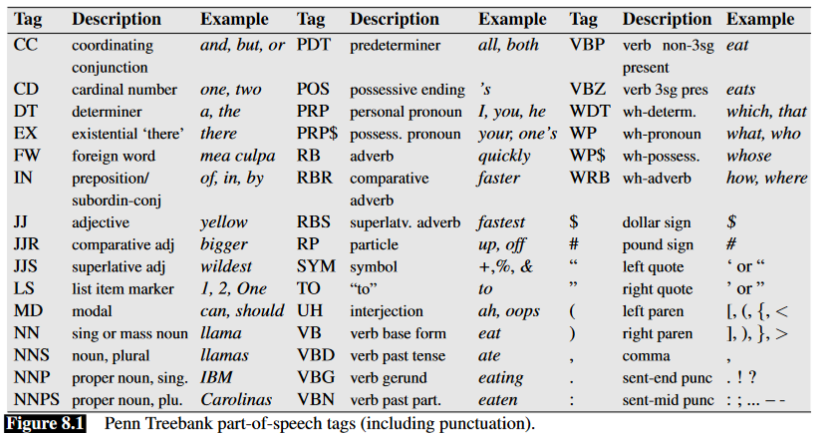

In [10]:
punctuation_tags = [',', '.', '``', "''", ':', '$', '-LRB-', '-RRB-', '#', 'SYM']
print(len(punctuation_tags))
punctuation_tags

10


[',', '.', '``', "''", ':', '$', '-LRB-', '-RRB-', '#', 'SYM']

In [11]:
tags = set(flatten((pos.split(words_separator) for pos in df.pos)))
n_tags   = len(tags)
print("Total number of tags: {}".format(n_tags))
print()
print('Tags')
print(tags)

Total number of tags: 45

Tags
{'JJS', ':', 'TO', 'VBG', 'PRP$', 'VBN', 'VBD', '.', 'PDT', 'NNPS', '-LRB-', 'VBP', 'DT', '``', 'JJ', "''", 'CD', 'RB', 'WP$', 'LS', 'MD', 'JJR', 'NN', 'WDT', 'RBR', 'IN', 'EX', 'PRP', 'NNS', 'WRB', 'RP', '#', '-RRB-', 'CC', 'NNP', '$', 'POS', 'SYM', 'UH', 'WP', 'VB', 'RBS', ',', 'FW', 'VBZ'}


In [12]:
tags = df[['pos', 'split']].copy()
tags['pos'] = tags['pos'].str.split(words_separator)
tags = tags.explode('pos')

The dataset is highly unbalanced: nouns, prepositions and proper nouns are the most common labels.

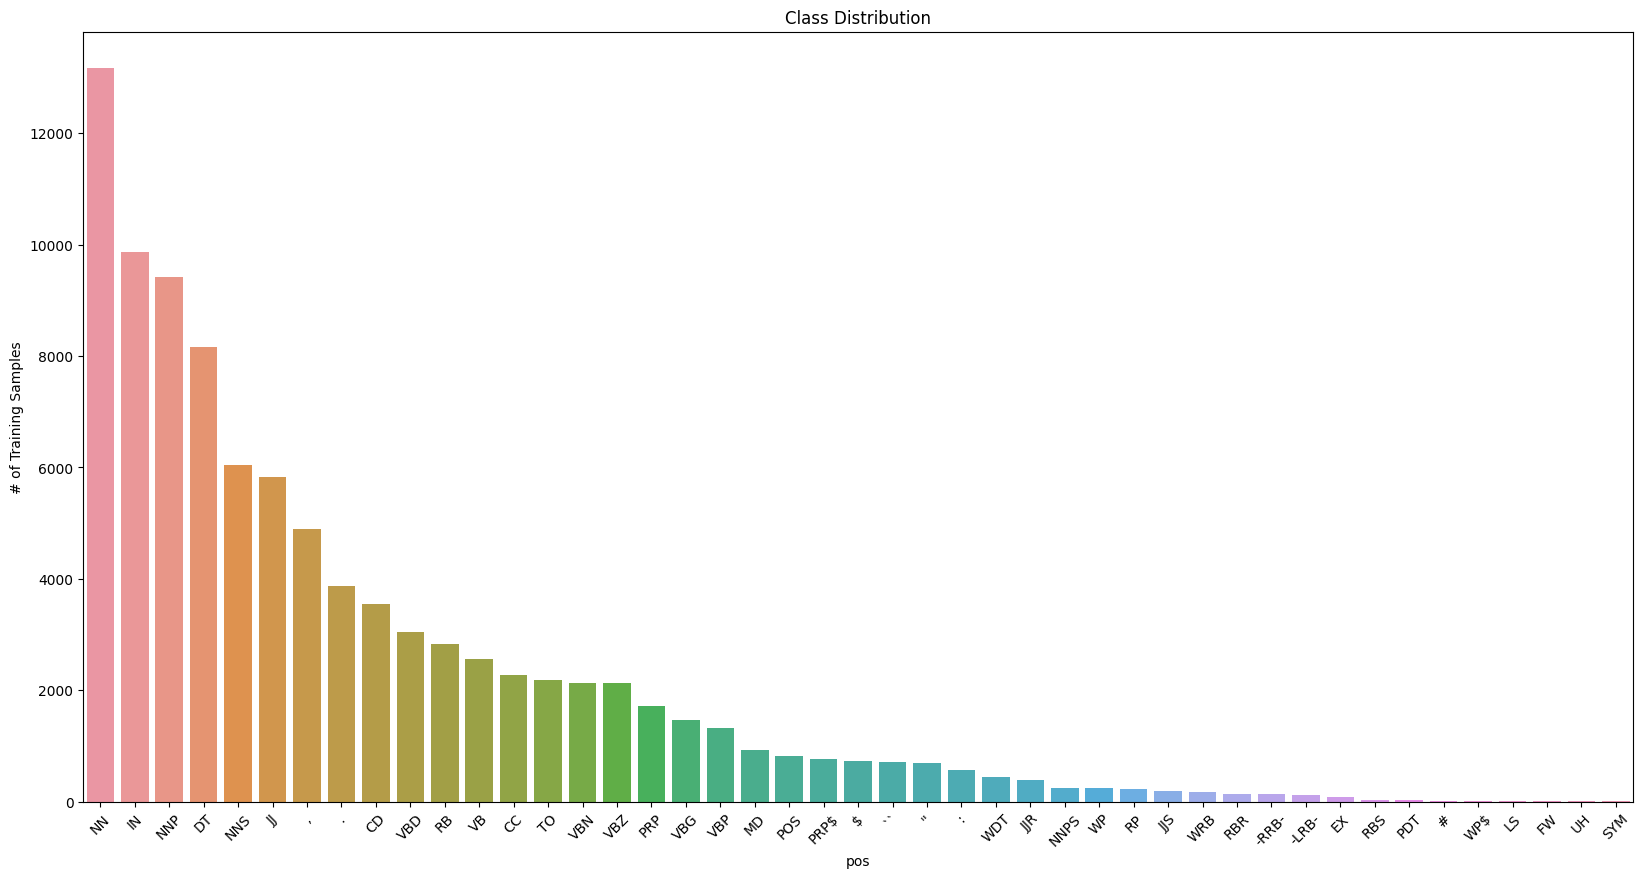

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(tags, x='pos', order=tags['pos'].value_counts().index, ax=ax);
plt.title('Class Distribution')
plt.ylabel('# of Training Samples')
plt.xticks(rotation = 45);

Classes are similarly distributed across the three splits

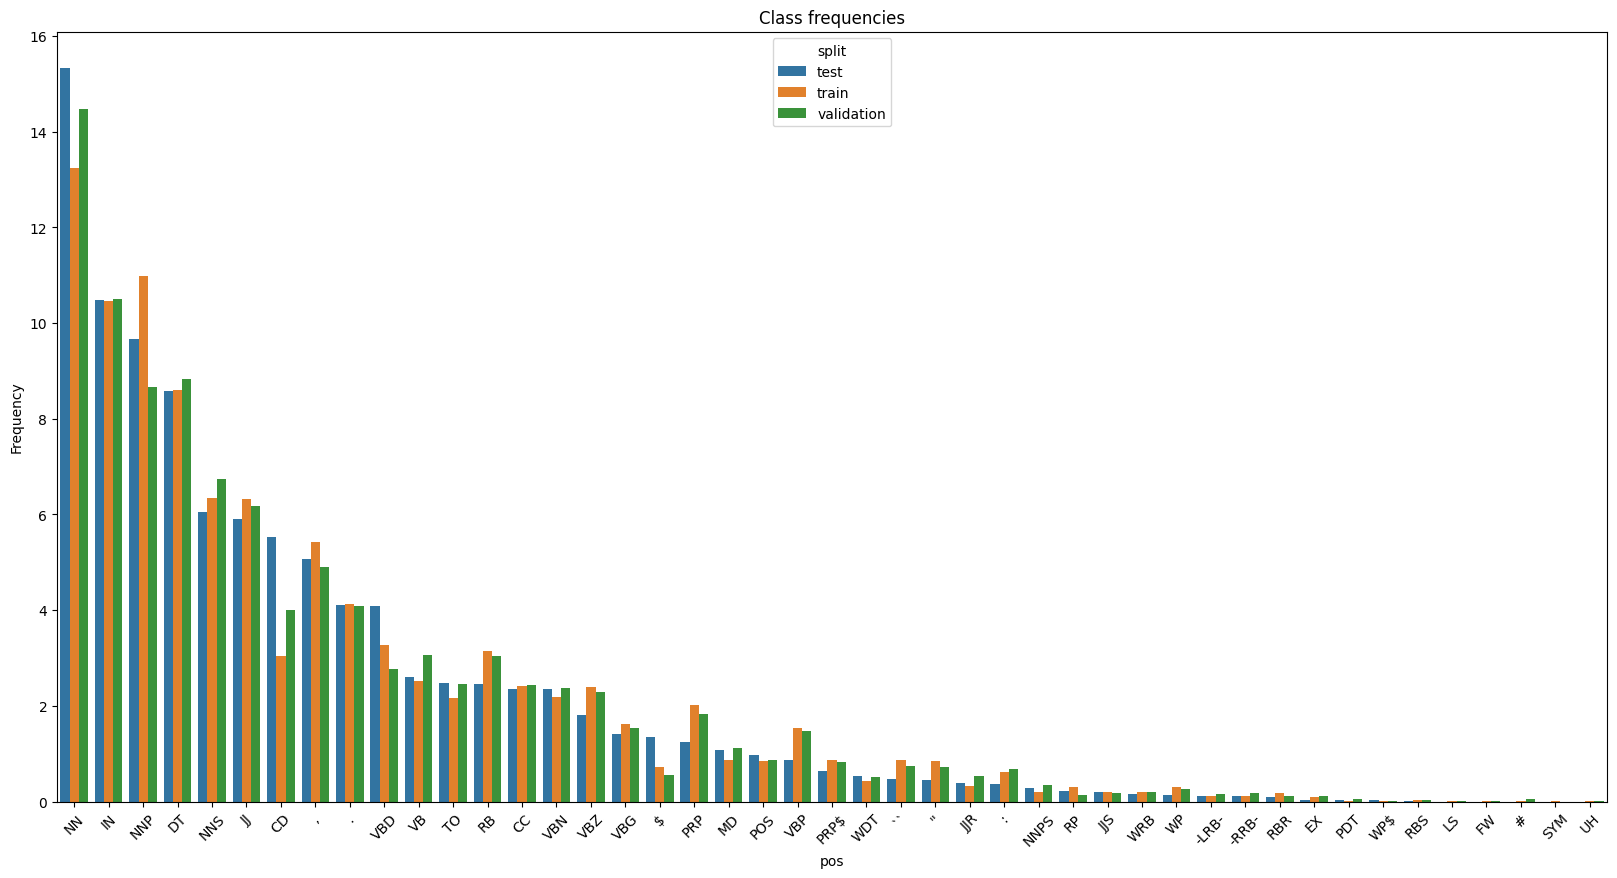

In [14]:
frequencies = (tags
    .groupby('split')['pos']
    .value_counts(normalize=True)
    .mul(100)
    .rename('frequency')
    .reset_index())

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(frequencies, x='pos', y='frequency', hue='split', ax=ax);
plt.title('Class frequencies')
plt.ylabel('Frequency')
plt.xticks(rotation = 45);

In [15]:
label_counts = pd.get_dummies(tags, columns=['pos'], prefix='', prefix_sep='').groupby('split').sum().reset_index()
cols = label_counts.columns[1:]
count_by_split = np.expand_dims(label_counts[cols].sum(axis=1), axis=1)
label_counts[cols] = label_counts[cols] / count_by_split
label_counts = label_counts.T.reset_index().rename(columns={'index':'pos', 0:'test', 1:'train', 2:'val'})[1:]
label_counts['punctuation'] = label_counts['pos'].isin(punctuation_tags)
label_counts.sort_values('test', ascending=False)

,pos,test,train,val,punctuation
20,NN,0.153297,0.132401,0.144726,False
14,IN,0.104857,0.10457,0.105025,False
21,NNP,0.096751,0.109849,0.086714,False
11,DT,0.08588,0.086071,0.088317,False
23,NNS,0.060534,0.063434,0.067409,False
15,JJ,0.059054,0.063181,0.0617,False
10,CD,0.055195,0.030387,0.040054,False
4,",",0.050627,0.054291,0.049001,True
7,.,0.041042,0.041368,0.040952,True
36,VBD,0.040785,0.032689,0.027611,False


In [16]:
label_counts.groupby('punctuation').sum().drop('pos', axis=1)

,test,train,val
punctuation,,,
False,0.879768,0.871569,0.879261
True,0.120232,0.128431,0.120739


Some classes are not present in the test set or in the validation set. In particular FW (foreign words), LS (list item markers), and UH (interjections)

In [17]:
cols = label_counts.columns[1:-1]
label_counts.loc[(label_counts[cols] == 0).any(axis=1)]

,pos,test,train,val,punctuation
1,#,0.0,0.000021,0.000481,True
13,FW,0.0,0.000042,0.000064,False
18,LS,0.0,0.000211,0.000096,False
32,SYM,0.0,0.000021,0.0,True
34,UH,0.0,0.000021,0.000064,False


### 1.1.3 Length Analysis

This analysis is useful to decide the padding strategy. Therefore, we should not consider data in the test set

In [18]:
data = df[df['split'] != 'test'].copy()
data['length'] = data['sentence'].str.split(words_separator).apply(len)

data['length'].describe()

count    3262.000000
mean       24.076947
std        12.229630
min         1.000000
25%        16.000000
50%        23.000000
75%        31.000000
max       249.000000
Name: length, dtype: float64

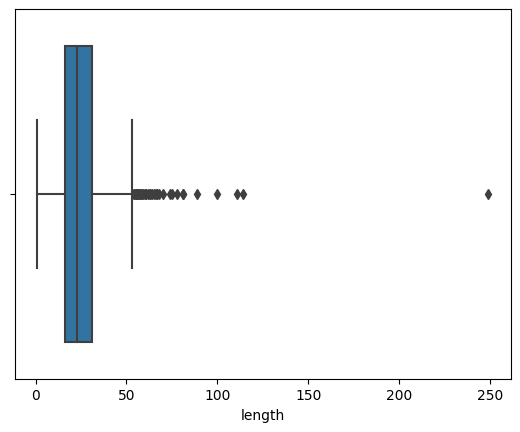

In [19]:
sns.boxplot(x=data['length']);

# 2 Data Preprocessing

In [20]:
def prepare_text(sentence: str) -> str:
  return sentence

df['sentence'] = df['sentence'].apply(prepare_text)
df

,sentence,pos,file_id,split
0,"Pierre Vinken , 61 years old , will join the b...","NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN ...",1,train
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...","NNP NNP VBZ NN IN NNP NNP , DT NNP VBG NN .",1,train
2,"Rudolph Agnew , 55 years old and former chairm...","NNP NNP , CD NNS JJ CC JJ NN IN NNP NNP NNP NN...",2,train
3,A form of asbestos once used to make Kent ciga...,DT NN IN NN RB VBN TO VB NNP NN NNS VBZ VBN DT...,3,train
4,"The asbestos fiber , crocidolite , is unusuall...","DT NN NN , NN , VBZ RB JJ IN PRP VBZ DT NNS , ...",3,train
...,...,...,...,...
3909,They also said that more than a dozen presiden...,PRP RB VBD IN JJR IN DT NN NNS VBP VBN IN JJ N...,198,test
3910,Sen. Kennedy said in a separate statement that...,NNP NNP VBD IN DT JJ NN IN PRP VBZ NN TO VB DT...,198,test
3911,Trinity Industries Inc. said it reached a prel...,NNP NNPS NNP VBD PRP VBD DT JJ NN TO VB CD NN ...,199,test
3912,Terms were n't disclosed .,NNS VBD RB VBN .,199,test


# 3 Data splitting

In [21]:
train_data = df[df['split'] == 'train']
val_data = df[df['split'] == 'validation']
test_data = df[df['split'] == 'test']

print('Dataset splits statistics: ')
print(f'Train data: {train_data.shape}')
print(f'Validation data: {val_data.shape}')
print(f'Test data: {test_data.shape}')

Dataset splits statistics: 
Train data: (1963, 4)
Validation data: (1299, 4)
Test data: (652, 4)


# 4 Data Conversion

In [22]:
def load_embedding_model(model_type: str='glove', embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [23]:
class Vocabulary:
  def __init__(self, padding=True) -> None:
    self.word_to_id = OrderedDict()
    self.id_to_word = OrderedDict()
    self.__id = 0

    if padding:
      self.word_to_id[''] = 0
      self.id_to_word[0] = ''
      self.__id += 1

  def update(self, tokens: Iterable[str], verbose=True) -> Iterable[str]:
    """
    Update the vocabulary by looking at the list of tokens in input.

    :return
        - OOV terms
    """
    old_len = len(self.word_to_id)

    oov = self.__compute_oov_terms(tokens)
    self.__expand_vocabulary(oov)

    if verbose:
      print(f"Total OOV terms:", len(oov))
      print("Vocabulary length before expansion:", old_len)
      print("Vocabulary length after expansion:", len(self.word_to_id))
  
  def __compute_oov_terms(self, tokens: Iterable[str]) -> Set[str]:
    """
    Get tokens which are not in the vocabulary.

    :return
        - OOV terms
    """
    tokens = set(tokens)
    oov = tokens.difference(self.word_to_id.keys())
    return oov

  def __expand_vocabulary(self, oov_terms: Iterable[str]):
    for term in oov_terms:
      self.word_to_id[term] = self.__id
      self.id_to_word[self.__id] = term
      self.__id += 1

  def __len__(self):
    return len(self.word_to_id)

In [24]:
class EmbeddingMatrix():
  def __init__(self,
               embedding_model: gensim.models.keyedvectors.KeyedVectors,
               embedding_dimension,
               word_to_id: Dict[str, int],
               oov_vector_factory = None) -> None:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param embedding_dimension: dimension of the vectors in the embedding space
    :param word_to_idx: vocabulary map (word -> index) (dict)
    """
    self.oov_vector_factory = oov_vector_factory if oov_vector_factory else lambda: np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

    vocab_size = len(word_to_id)
    self.embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_id.items()):
      if word in embedding_model:
        embedding_vector = embedding_model[word]
      else:
        embedding_vector = self.oov_vector_factory()

      self.embedding_matrix[idx] = embedding_vector

  def update(self, word_to_idx: Dict[str, int]):
    old_vocab_size = len(self.embedding_matrix)
    vocab_size = len(word_to_idx)
    embedding_dimension = self.embedding_matrix.shape[1]

    self.embedding_matrix.resize((vocab_size, embedding_dimension))
    for word, idx in tqdm(word_to_idx.items()):
      if idx > old_vocab_size -1:
        self.embedding_matrix[idx] = self.oov_vector_factory()

  def numpy(self):
    return self.embedding_matrix

In [25]:
model_type = 'glove'
embedding_dimension = 50

embedding_model = load_embedding_model(model_type=model_type, embedding_dimension=embedding_dimension)

In [26]:
def add_oov(vocabulary: Vocabulary, embedding_matrix: EmbeddingMatrix, dataset, dataset_name: str):
  print()
  print(f'Adding {dataset_name} vocabulary ...')

  tokens = flatten(dataset.sentence.str.split(words_separator))
  vocabulary.update(tokens)
  embedding_matrix.update(vocabulary.word_to_id)

def build_vocabulary_and_embedding(embedding_model: gensim.models.keyedvectors.KeyedVectors):
  vocabulary = Vocabulary()

  embedding_terms = embedding_model.key_to_index.keys()
  vocabulary.update(embedding_terms)

  embedding_matrix = EmbeddingMatrix(embedding_model, embedding_dimension, vocabulary.word_to_id)

  add_oov(vocabulary, embedding_matrix, train_data, 'training set')
  add_oov(vocabulary, embedding_matrix, val_data, 'validation set')
  add_oov(vocabulary, embedding_matrix, test_data, 'test set')

  return vocabulary, embedding_matrix

vocabulary, embedding_matrix = build_vocabulary_and_embedding(embedding_model)

Total OOV terms: 400000
Vocabulary length before expansion: 1
Vocabulary length after expansion: 400001


100%|██████████| 400001/400001 [00:01<00:00, 202288.87it/s]



Adding training set vocabulary ...
Total OOV terms: 2346
Vocabulary length before expansion: 400001
Vocabulary length after expansion: 402347


100%|██████████| 402347/402347 [00:00<00:00, 1458670.98it/s]



Adding validation set vocabulary ...
Total OOV terms: 944
Vocabulary length before expansion: 402347
Vocabulary length after expansion: 403291


100%|██████████| 403291/403291 [00:00<00:00, 1292321.71it/s]



Adding test set vocabulary ...
Total OOV terms: 455
Vocabulary length before expansion: 403291
Vocabulary length after expansion: 403746


100%|██████████| 403746/403746 [00:00<00:00, 1501201.60it/s]


In [27]:
label_vocabulary = Vocabulary()
labels = flatten((pos.split(words_separator) for pos in df.pos))
label_vocabulary.update(labels)

assert len(label_vocabulary) == n_tags + 1

Total OOV terms: 45
Vocabulary length before expansion: 1
Vocabulary length after expansion: 46


In [28]:
class TextVectorization:
    def __init__(self, word_to_id: Dict[str, int], sep=' ') -> None:
        self.sep = sep

        words = list(word_to_id.keys())
        values = list(word_to_id.values())
        self.word_to_id = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(words, values),
            default_value=-1
        )
        self.id_to_word = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(values, words),
            default_value='[UNK]'
        )
        assert self.word_to_id.size() == len(word_to_id)
        assert self.id_to_word.size() == len(word_to_id)

    def vectorize(self, text, padding=False) -> tf.Tensor | tf.RaggedTensor:
        tokens = self.tokenize(text, padding=padding)
        return self.tokens_to_ids(tokens)
    
    def invert(self, ids: tf.RaggedTensor) -> tf.Tensor:
        tokens = self.ids_to_tokens(ids)
        texts = tf.strings.reduce_join(tokens, separator=self.sep, axis=-1)
        return texts

    def tokenize(self, text, padding=False) -> tf.Tensor | tf.RaggedTensor:
        tokens = tf.strings.split(text, sep=self.sep)
        if padding:
            tokens = tokens.to_tensor(default_value='')

        return tokens

    def tokens_to_ids(self, tokens: tf.Tensor | tf.RaggedTensor) -> tf.Tensor | tf.RaggedTensor:
        return tf.ragged.map_flat_values(self.word_to_id.lookup, tokens)
    
    def ids_to_tokens(self, ids: tf.RaggedTensor) -> tf.RaggedTensor:        
        ids = tf.cast(ids, tf.int32)
        tokens = tf.ragged.map_flat_values(self.id_to_word.lookup, ids)
        return tokens

tokenizer = TextVectorization(vocabulary.word_to_id)
label_tokenizer = TextVectorization(label_vocabulary.word_to_id)

assert tf.reduce_all(tokenizer.invert(tokenizer.vectorize(train_data.sentence.values)) == tf.constant(train_data.sentence.values))
assert tf.reduce_all(label_tokenizer.invert(label_tokenizer.vectorize(train_data.pos.values)) == tf.constant(train_data.pos.values))

In [29]:
def pad(sentences: tf.RaggedTensor, tags: tf.RaggedTensor):
  sentences = sentences.to_tensor(default_value=0)
  tags = tags.to_tensor(default_value=0)

  return sentences, tags

# workaround to avoid lambda functions
def one_hot_encode_labels(sentences: tf.Tensor, tags: tf.Tensor, num_classes, ignore_padding):
  return sentences, one_hot(tags, num_classes, ignore_padding)

def one_hot(inputs: tf.Tensor, num_classes, ignore_padding=False):
  if ignore_padding:
    # supposing padding=0 -> padding=-1 -> padding = [0,...,0]
    inputs -= 1
  else:
    num_classes += 1
  return tf.one_hot(inputs, depth=num_classes)

def create_dataloader(
  dataset: pd.DataFrame,
  tokenizer: TextVectorization,
  label_tokenizer: TextVectorization,
  batch_size=32,
  multi_label=False, training=True):

  sentences = tokenizer.vectorize(dataset['sentence'])
  labels = label_tokenizer.vectorize(dataset['pos'])

  dataset = (
      tf.data.Dataset.from_tensor_slices((sentences, labels))
  )
  
  if training:
    dataset = dataset.shuffle(buffer_size=2048)

  # workaround to avoid lambda functions
  encode_labels = functools.partial(one_hot_encode_labels, num_classes=n_tags, ignore_padding=multi_label)

  dataset = (
      dataset
      .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
      .map(pad, num_parallel_calls=tf.data.AUTOTUNE)
      .map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
      )
  
  return dataset

dataloader = create_dataloader(train_data, tokenizer, label_tokenizer)

In [30]:
batched_text, batched_tags = next(dataloader.take(1).as_numpy_iterator())
text = batched_text[0]
tags = batched_tags[0]

print('Encoded text:', text.shape)
print(text)
print('One hot encoded tags:', tags.shape)
print(tags)

Encoded text: (51,)
[312725 400561 377164 363652 179336 315293 100727 283888  48664 323946
 205705  41318 218419 191553 185885      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0]
One hot encoded tags: (51, 46)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


# 5 Model Definition

In [31]:
# n_labels = n_tags if multilabel else n_tags + 1
def create_model(embedding_weights, n_labels, compile_info, dtype=tf.float32):
  inputs = ks.layers.Input(shape=(None, ))
  x = ks.layers.Embedding(*embedding_weights.shape, weights=[embedding_weights],
                          mask_zero=True, trainable=False)(inputs)
  x = ks.layers.Bidirectional(ks.layers.LSTM(units=64, return_sequences=True))(x)
  x = ks.layers.TimeDistributed(ks.layers.Dense(n_labels, activation='softmax', dtype=dtype))(x)

  model = ks.models.Model(inputs, x)
  model.summary()
  model.compile(**compile_info)

  return model

embedding_weights = embedding_matrix.numpy()

In [32]:
compile_info = {
    'optimizer': ks.optimizers.Adam(learning_rate=1e-3),
    'loss': 'categorical_crossentropy',
    'metrics': ['accuracy'],
}
model = create_model(embedding_weights, n_labels=n_tags+1, compile_info=compile_info)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          20187300  
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        58880     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, None, 46)         5934      
 ibuted)                                                         
                                                                 
Total params: 20,252,114
Trainable params: 64,814
Non-trainable params: 20,187,300
_________________________________________________________________


# 6 Training

In [33]:
def show_history(history: ks.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    history_data = history.history
    print(f"Displaying the following history keys: {history_data.keys()}")

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if f'val_{key}' in history_data:
                ax.plot(history_data[f'val_{key}'])
            else:
                print(f"Couldn't find validation values for metric: {key}")

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')
    plt.show()

In [34]:
def train_model(model: ks.Model,
                train_data: tf.data.Dataset,
                val_data: tf.data.Dataset,
                training_info: Dict,
                show=True):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param train_data: training data
    :param val_data: validation data
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print(f"Start training! \nParameters: {training_info}")
    history = model.fit(x=train_data,
                        validation_data=val_data,
                        **training_info)
    print("Training completed!")

    if show:
        print("Showing history...")
        show_history(history)

    return history

Start training! 
Parameters: {'verbose': 1, 'epochs': 5, 'batch_size': 64}
Epoch 1/5
31/31 [==============================] - 20s 262ms/step - loss: 3.2186 - accuracy: 0.1603 - val_loss: 2.8048 - val_accuracy: 0.2591
Epoch 2/5
31/31 [==============================] - 3s 112ms/step - loss: 2.5551 - accuracy: 0.3557 - val_loss: 2.3258 - val_accuracy: 0.4337
Epoch 3/5
31/31 [==============================] - 4s 118ms/step - loss: 2.0648 - accuracy: 0.5009 - val_loss: 1.8668 - val_accuracy: 0.5385
Epoch 4/5
31/31 [==============================] - 4s 133ms/step - loss: 1.6552 - accuracy: 0.5889 - val_loss: 1.5411 - val_accuracy: 0.6040
Epoch 5/5
31/31 [==============================] - 4s 132ms/step - loss: 1.3818 - accuracy: 0.6516 - val_loss: 1.3323 - val_accuracy: 0.6528
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


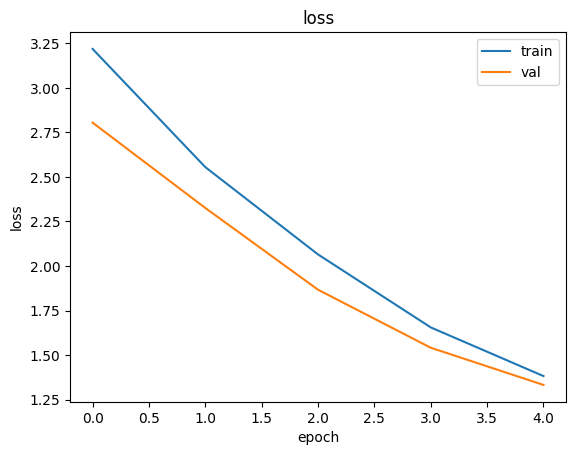

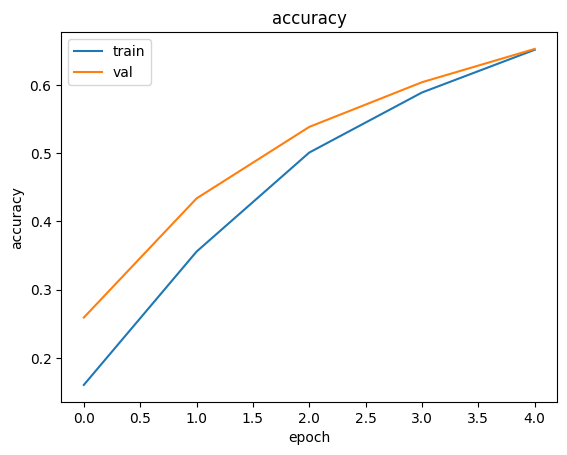

In [35]:
training_info = {
    'verbose': 1,
    'epochs': 5,
    'batch_size': 64,
}

train_dataloader = create_dataloader(train_data, tokenizer, label_tokenizer, batch_size=training_info['batch_size'])
val_dataloader = create_dataloader(val_data, tokenizer, label_tokenizer, batch_size=training_info['batch_size'])
history = train_model(model=model, train_data=train_dataloader, val_data=val_dataloader, training_info=training_info)

# 7 Evaluation

## 7.1 Inference

In [36]:
def predict_data(model: ks.Model,
                 data: tf.data.Dataset,
                 prediction_info: Dict) -> tf.Tensor:
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param data: input set of examples
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels
    """
    print(f'Starting prediction: \n{prediction_info}')

    predictions = model.predict(data, **prediction_info)
    return predictions.to_tensor(default_value=0)

def predictions_to_ids(predictions: tf.Tensor) -> tf.Tensor:
    tags = tf.argmax(predictions, axis=-1, output_type=tf.int32)
    assert predictions.shape[:2] == tags.shape

    return tags

In [54]:
prediction_info = {
    'batch_size': 64,
    'verbose': 1
}

test_loader = create_dataloader(test_data, tokenizer, label_tokenizer, training=False)
predictions = predict_data(model=model, data=test_loader, prediction_info=prediction_info)

assert len(predictions) == len(test_data)
max_length = test_data['sentence'].str.split(words_separator).apply(len).max()
assert predictions.shape[1] == max_length

predictions = predictions_to_ids(predictions)
predictions = label_tokenizer.ids_to_tokens(predictions)

Starting prediction: 
{'batch_size': 64, 'verbose': 1}
21/21 [==============================] - 0s 15ms/step


In [55]:
print(predictions.shape)
print(predictions[0:10])

(652, 58)
tf.Tensor(
[[b'NNP' b'NNP' b'NNP' b',' b'NNP' b'NNP' b',' b'NNP' b',' b'VBD' b'VBZ'
  b'VBD' b'CD' b'CD' b'NN' b',' b'NN' b'IN' b'CD' b'CD' b',' b'IN' b'NN'
  b'JJ' b'NN' b'IN' b'DT' b'JJ' b'NN' b'IN' b'$' b'CD' b'DT' b'NN' b','
  b'IN' b'$' b'CD' b'CD' b'.' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
  b'' b'' b'' b'' b'' b'' b'']
 [b'NNP' b'DT' b'NN' b'NNP' b'NNP' b'NNP' b'NNP' b'POS' b'NN' b'TO' b'CD'
  b'CD' b'IN' b'CD' b'CD' b'CC' b'TO' b'VB' b'VB' b'NNP' b'NNP' b'IN'
  b'NN' b'DT' b'NN' b'IN' b'DT' b'NN' b'NN' b'.' b'.' b'.' b'.' b'.' b'.'
  b'.' b'.' b'.' b'.' b'.' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
  b'' b'' b'' b'' b'' b'' b'']
 [b'NNP' b'NNP' b'RB' b'DT' b'VB' b'TO' b'TO' b'NNP' b'NNP' b'NN' b'NN'
  b'IN' b'NNP' b'NNP' b',' b'DT' b'NNP' b'NN' b'.' b'.' b'.' b'.' b'.'
  b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.' b'.'
  b'.' b'.' b'.' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
  b'' b'' b'' b'']
 [b'NNP' b'DT' b'NN' b'VBD' b

## 7.2 Evaluation

In [93]:
def compute_blacklist_mask(y_true: tf.Tensor, black_list: Iterable[str]) -> tf.Tensor:
  return ~tf_in(y_true, black_list)

def compute_padding_mask(y_true: tf.Tensor) -> tf.Tensor:
  return y_true != ''

def compute_mask(y_true: tf.Tensor, black_list: Iterable[str]) -> tf.Tensor:
  padding_mask = compute_padding_mask(y_true)
  blacklist_mask = compute_blacklist_mask(y_true, black_list)
  return tf.logical_and(padding_mask, blacklist_mask)

def take_valid_labels(y_pred: tf.Tensor, y_true: Iterable[str], label_tokenizer:TextVectorization, banned_tags) -> Tuple[tf.RaggedTensor, tf.RaggedTensor]:
  assert len(y_pred) == len(y_true)
  y_true = label_tokenizer.tokenize(y_true).to_tensor(default_value='', shape=y_pred.shape)
  mask = compute_mask(y_true, banned_tags)
  assert mask.shape == y_pred.shape, f'{mask.shape} != {y_pred.shape}'

  masked_pred = tf.ragged.boolean_mask(y_pred, mask)
  masked_true = tf.ragged.boolean_mask(y_true, mask)

  return masked_pred, masked_true

def evaluate_predictions(
  y_pred: tf.Tensor,
  y_true: Iterable[str],
  metrics: Dict[str, Callable],
  label_tokenizer:TextVectorization,
  banned_tags:Iterable[str],
  dtype=str) -> Tuple[tf.Tensor, tf.Tensor, Dict[str, object]]:
  """
    Evaluates given model predictions on a list of metric functions

    :param y_pred: model predictions
    :param y_true: ground-truth labels
    :param metrics: dictionary of (metric_name, metric_fn)
    :param banned_tags: list of tags to filter out from evaluation

    :return
      - filtered prediction labels
      - filtered true lables
      - metric_info: dictionary containing metric values for each input metric
    """
  print(f"Evaluating predictions! Total samples: {y_pred.shape[0]}")  
  masked_pred, masked_true = take_valid_labels(y_pred, y_true, label_tokenizer=label_tokenizer, banned_tags=banned_tags)
  assert masked_pred.shape == masked_true.shape

  # masked_true = label_tokenizer.tokens_to_ids(masked_true)

  masked_pred = np.array(tf.reshape(masked_pred, -1), dtype=dtype)
  masked_true = np.array(tf.reshape(masked_true, -1), dtype=dtype)

  metric_info = {}
  for metric_name, metric in metrics.items():
      metric_value = metric(y_pred=masked_pred, y_true=masked_true)
      metric_info[metric_name] = metric_value

  return masked_pred, masked_true, metric_info
  

def _test_evaluate():
  print('Testing evaluation functions ...')
  y_pred = [
  ['NN', 'RBR', 'CC', '', ''],
  ['JJ', 'JJ', 'IN', 'WDT', '']]
  y = tf.constant(y_pred)

  y_true = [words_separator.join(lbls).strip() for lbls in y_pred]
  # alter pred from true
  y_pred[0][1] = 'WDT'
  y_pred[1][1] = 'CC'
  y_pred = tf.constant(y_pred)
  banned_tags = ['NN', 'CC', 'JJ']

  padding_mask = compute_padding_mask(y)
  assert len(padding_mask) == len(y), f'{len(padding_mask)} != {len(y)}'
  assert padding_mask.shape == y.shape, f'{padding_mask.shape} != {y.shape}'
  assert tf.reduce_all(padding_mask == tf.constant([[True, True, True, False, False], [True, True, True, True, False]]))

  blacklist_mask = compute_blacklist_mask(y, banned_tags)
  assert len(blacklist_mask) == len(y), f'{len(blacklist_mask)} != {len(y)}'
  assert blacklist_mask.shape == y.shape, f'{blacklist_mask.shape} != {y.shape}'
  assert tf.reduce_all(blacklist_mask == tf.constant([[False, True, False, True, True], [False, False, True, True, True]]))

  mask = compute_mask(y, banned_tags)
  assert len(mask) == len(y), f'{len(mask)} != {len(y)}'
  assert mask.shape == y.shape, f'{mask.shape} != {y.shape}'
  assert tf.reduce_all(mask == tf.constant([[False, True, False, False, False], [False, False, True, True, False]]))

  pred, true = take_valid_labels(y_pred, y_true, label_tokenizer=label_tokenizer, banned_tags=banned_tags)
  assert pred.shape[0] == len(y_true)
  assert pred.shape == true.shape
  assert tf.reduce_all(pred == tf.ragged.constant([['WDT'], ['IN', 'WDT']]))
  assert tf.reduce_all(true == tf.ragged.constant([['RBR'], ['IN', 'WDT']]))
  
  print('Test successfully completed!')

_test_evaluate()

Testing evaluation functions ...
Test successfully completed!


In [109]:
valid_labels = list(set(label_vocabulary.word_to_id.keys()).difference(banned_tags + ['']))

metrics = {
    'macro_f1': functools.partial(f1_score, zero_division=0, average='macro', labels=valid_labels),
    'classification report': functools.partial(classification_report, zero_division=0, labels=valid_labels),
}

y_pred, y_true, metric_info = evaluate_predictions(
    y_pred=predictions, y_true=test_data['pos'].values,
    metrics=metrics,
    label_tokenizer=label_tokenizer,
    banned_tags=banned_tags)

for metric_name, metric, in metric_info.items():
    print(metric_name)
    print(metric)

Evaluating predictions! Total samples: 652
macro_f1
0.2945691344672793
classification report
              precision    recall  f1-score   support

         JJS       0.00      0.00      0.00        31
          TO       0.81      0.99      0.89       386
         VBG       0.00      0.00      0.00       221
        PRP$       1.00      0.01      0.02        99
         VBN       0.55      0.19      0.29       366
         VBD       0.60      0.57      0.59       634
         PDT       0.00      0.00      0.00         4
        NNPS       0.00      0.00      0.00        44
         VBP       0.53      0.46      0.49       134
          DT       0.76      0.82      0.79      1335
          JJ       0.41      0.28      0.34       918
          CD       0.76      0.76      0.76       858
          RB       0.34      0.30      0.32       381
         WP$       0.00      0.00      0.00         4
          LS       0.00      0.00      0.00         0
          MD       0.97      0.17      0.2

In [110]:
print('Banned tags with support > 0')
print(np.unique(y_pred[tf_in(y_pred, banned_tags)]))

Banned tags with support > 0
['$' ',' '.' ':' '``']


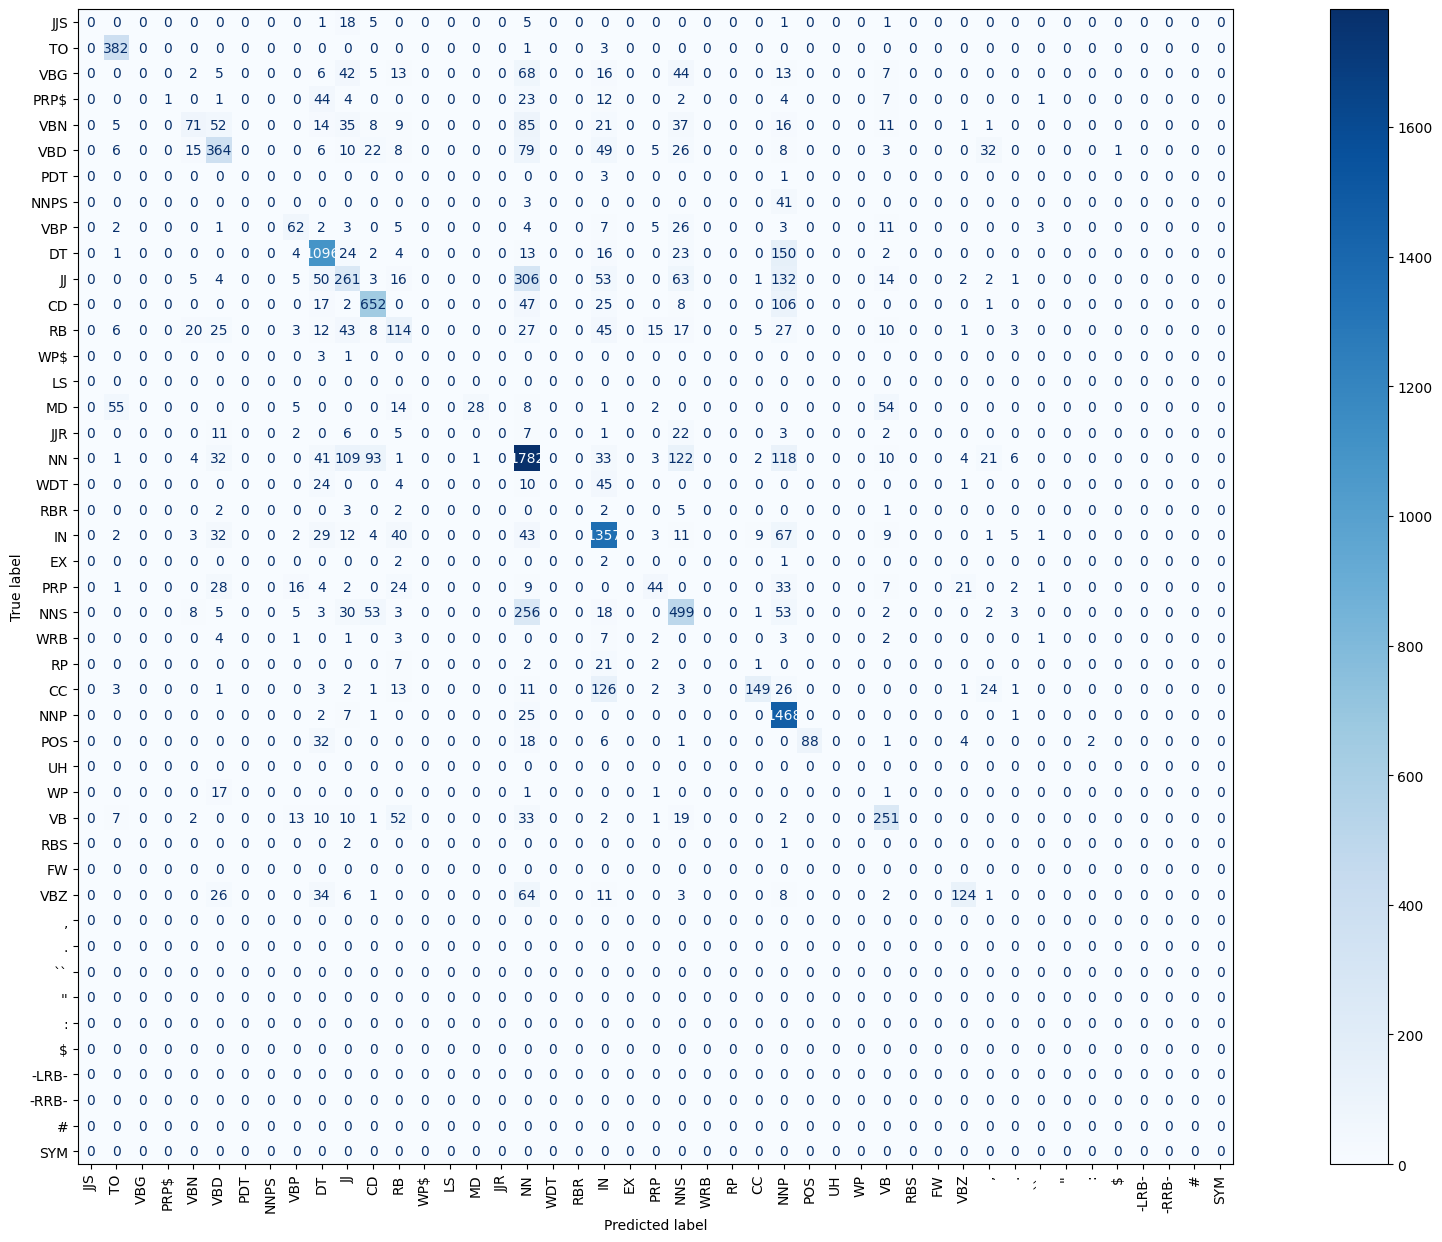

In [111]:
labels = valid_labels + banned_tags
fig, ax = plt.subplots(figsize=(25,15))
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap='Blues', xticks_rotation='vertical', ax=ax);